In [4]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./train.csv")

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df.label.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

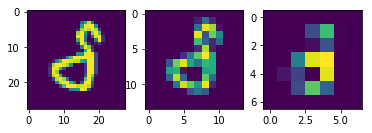

In [114]:
img = df.iloc[125][1:].reshape(28,28).astype(np.uint8)

fig,axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(cv2.resize(img,(14,14)))
axes[2].imshow(cv2.resize(img,(7,7)))

In [134]:
def crop(img,size=28):
    
    H_MIN,H_MAX = np.where(img.std(axis=1)>8)[0][[0,-1]]
    W_MIN,W_MAX = np.where(img.std(axis=0)>8)[0][[0,-1]]
    
    img = img[H_MIN:H_MAX,W_MIN:W_MAX]
    img = np.pad(img,pad_width=2)
    
    return cv2.resize(img.astype(np.uint8),(size,size))

def input_gen(df,epochs=10,_crop=True):
    for epoch in range(epochs):
        for i in range(df.shape[0]):
            row = df.iloc[i].values
            y = ohe.transform([[row[0]]])
            img_28 = crop(row[1:].reshape(28,28))
            img_14 = crop(row[1:].reshape(28,28),size=14)
            yield (
                {
                    "input_28":img_28.reshape(1,28,28,1)/255,
#                     "input_14":img_14.reshape(1,14,14,1)/255
                },
                {"output":y}
            )

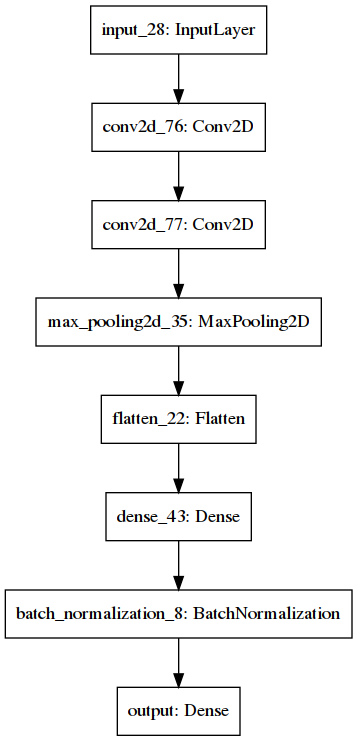

In [135]:
input_28 = Input(shape=(28,28,1),name="input_28")
model_28 = Conv2D(32,3,activation="relu",input_shape=(28,28,1))(input_28)
model_28 = Conv2D(64,3,activation="relu",)(model_28)
model_28 = MaxPool2D(pool_size=(3))(model_28)
model_28 = Flatten()(model_28)
model_28 = Dense(1024,activation="relu")(model_28)
model_28 = BatchNormalization(momentum=0.9)(model_28)

# input_14 = Input(shape=(14,14,1),name="input_14")
# model_14 = Conv2D(16,3,activation="relu",input_shape=(14,14,1))(input_14)
# model_14 = Conv2D(32,3,activation="relu",)(model_14)
# model_14 = MaxPool2D(pool_size=(3))(model_14)
# model_14 = Flatten()(model_14)
# model_14 = Dense(512,activation="relu")(model_14)
# model_14 = BatchNormalization(momentum=0.9)(model_14)

# merge = concatenate([model_14,model_28])

output = Dense(10,activation="softmax",name="output")(model_28)
model = Model(inputs=[input_28],outputs=[output])

from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
model.fit_generator(input_gen(df),steps_per_epoch=df.shape[0],epochs=10)

Epoch 1/10
